In [1]:
import logging
from logging import getLogger
import sys
import pynq
import time
from pynq import PL
import os, time

import numpy as np
from fpbinary import FpBinary
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, fftshift
import scipy.io as sio

from pynq import Overlay
import mkidgen3 as g3
import mkidgen3.mkidpynq as mkidpynq
import mkidgen3.util
import mkidgen3.plotting
from mkidgen3.plotting import plot_waveforms, plot_res_chan
from mkidgen3.daccomb import generate_dac_comb
from mkidgen3.drivers import axiswitch, bintores, capture, ddc, dactable, axififo, rfdc
from mkidgen3.drivers.ifboard import IFBoard
from mkidgen3.drivers.ppssync import *
from mkidgen3.server.feedline_config import *
from mkidgen3.util import setup_logging
from mkidgen3.server.waveform import WaveformFactory

In [2]:
# 1.1.1 Set Board Timezone

In [3]:
os.environ['TZ'] = 'right/UTC'
time.tzset()

In [4]:
#setup_logging('feedlinereadoutserver');
#getLogger('pynq.interrupt').setLevel('DEBUG')
#getLogger('pynq.uio').setLevel('DEBUG')

## 1.2 Setup Logging, Clocking, and Download Overlay

In [5]:
# Download Overlay, Optionally Configure Clocks
bitstream='/home/xilinx/gen3_top_final.bit'
mkidgen3.drivers.rfdcclock.configure(programming_key='4.096GSPS_MTS_dualloop',clock_source='external')
time.sleep(0.5)
ol = Overlay(bitstream, ignore_version=True, download=True)
mkidgen3.quirks.Overlay(ol).post_configure()
ol.rfdc.enable_mts()

## 1.2.1 Start PPS SYNC

In [6]:
ol.pps_synchronization.pps_synchronizer_con_0.start_engine(PPSMode.FORCE_START, skew = 1000*1000*1000,
                                                                  clk_period_ns=1/256e-3)

## Power on IF Board

In [7]:
ifb = IFBoard()
print(ifb.status())
ifb.power_on()

IFStatus: Unpowered, boot 122, freshly booted. LO gen3 fractional mode, full calibration. PLL unlocked.
	Req: 6000 MHz Attained: None MHz Err: nan MHz
	DAC attens: (31.75, 28.25)
	ADC Attens: (0.0, 0.0)


In [8]:
ifb.set_attens(output_attens=50, input_attens=10)
ifb.set_lo(6000.0)
print(ifb.status())

IFStatus: Powered, boot 122. LO gen3 fractional mode, full calibration. PLL locked.
	Req: 6000 MHz Attained: 6000 MHz Err: 0 MHz
	DAC attens: (31.75, 18.25)
	ADC Attens: (0.0, 10.0)


## Configure DAC

In [9]:
#Set tones to send (in Hz). Domain is [-2047,2048) MHz. Set the SNR for a noise floor, `'max'` will turn off noise.
tones = np.array([100e6])

#tones = np.linspace(center - 0.5e6, center + 0.5e6, 64)
amplitudes = np.ones_like(tones)/tones.shape[0]


In [10]:
waveform = WaveformConfig(waveform=WaveformFactory(frequencies=tones, amplitudes=amplitudes, maximize_dynamic_range=False))

In [11]:
if not hasattr(ol, 'dac_table'):
    def dac_config(*args, **kwargs):
        packed_data = np.zeros(2 ** 20, dtype=np.uint16)
        data=kwargs['waveform'].output_waveform
        iload = data.real.astype(np.int16)
        qload = data.imag.astype(np.int16)
        for i in range(8):
            packed_data[i:data.size * 2:16] = iload[i::8]
            packed_data[i + 8:data.size * 2:16] = qload[i::8]
        ol.dactable.axi_bram_ctrl_0.mmio.array[:]=np.frombuffer(packed_data, dtype=np.uint32)
        time.sleep(1)
else:
    def dac_config(*args, **kwargs):
        ol.dac_table.configure(**kwargs)

In [12]:
dac_config(**waveform.settings_dict())

## ADC Capture

In [15]:
# Trigger Capture
x = ol.capture.capture_adc(2**19, complex=False)  # throw away capture to clear any startup garbage
del x
adc_capture_data = ol.capture.capture_adc(2**19, complex=True)
adc_capture_data/=2**16  #Normalize to 1/2 V
# Plot ADC Data
timerange = (0,120)  # ns
fftrange= (16, 16 + 20*4096) 
fftzoom = (1.5e8, 3.1e8)
mkidgen3.plotting.adc_test_plot(adc_capture_data, timerange, fftrange, fftzoom)

OSError: capture core not ready, this shouldn't happen. Try calling .axis2mm.abort() followed by .axis2mm.clear_error() then try a small throwaway capture (data order may not be aligned in the first capture after a reset).

# Program Bin2Res and DDC

In [23]:
chan = waveform.default_channel_config
ol.photon_pipe.reschan.bin_to_res.configure(**chan.settings_dict())

In [25]:
ddc = waveform.default_ddc_config
ol.photon_pipe.reschan.ddccontrol_0.configure(**ddc.settings_dict())

# Load Unity Matched Filters

In [36]:
filtercfg=FilterConfig(coefficients=f'unity{2048}')
ol.photon_pipe.phasematch.configure(**filtercfg.settings_dict())

## Capture Helper Functions

In [37]:
def cap_cordic_compare(self, n_points=1024):
    """A helper function to capture data just before lowpass and after conversion to phase"""
    x = self.capture_iq(n_points, 'all', tap_location='rawiq')
    rawiq = np.array(x)
    x.freebuffer()
    x = self.capture_iq(n_points, 'all', tap_location='ddciq')
    ddciq = np.array(x)
    x.freebuffer()
    x = self.capture_phase(n_points, 'all', tap_location='filtphase')
    phase = np.array(x)
    x.freebuffer()
    rawiq = rawiq[..., 0] + rawiq[..., 1] * 1j
    ddciq = ddciq[..., 0] + ddciq[..., 1] * 1j
    return rawiq, ddciq, phase

# Check DDC

434 443


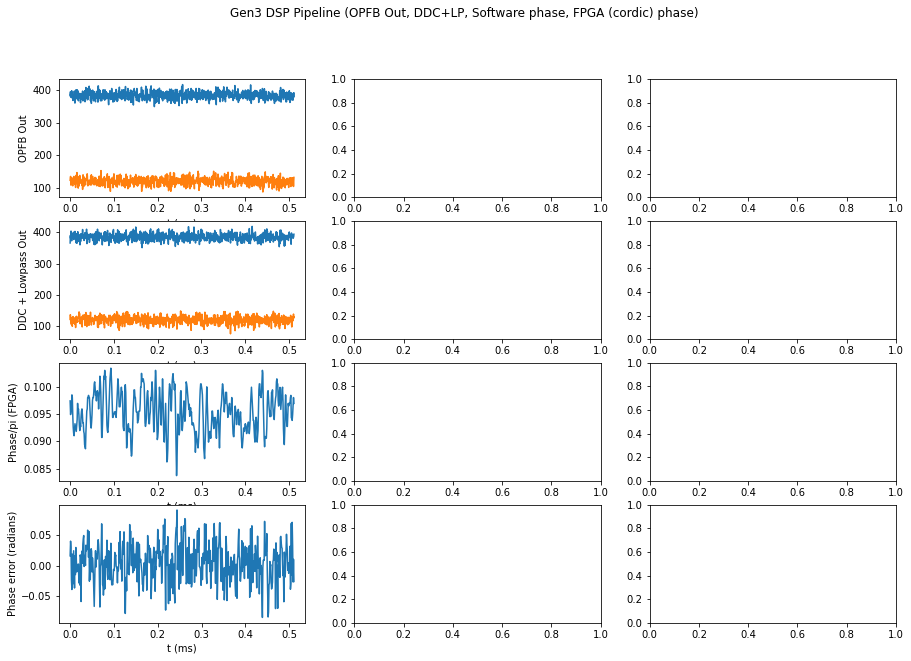

In [12]:
#riq, iq = ol.capture.ddc_compare_cap()
rawiq, ddciq, phase = cap_cordic_compare()
tonesplt = tones
chan_plt=[0,1]
bin_centers = g3.opfb_bin_center(g3.opfb_bin_number(tonesplt, ssr_raw_order=True), ssr_order=True)
fig, axes = plt.subplots(5,len(chan_plt), figsize=(15,10))
tones_khz=g3.drivers.ddc.tone_increments(tonesplt, quantize=True)*1e3
for j,(i, ax) in enumerate(zip(chan_plt,axes.T)):
    plot_waveforms(rawiq[:100, i], 2e6, mode='iq', ax=ax[0], label='OPFB Out' if not j else '')
    plot_waveforms(ddciq[:100, i], 2e6, mode='iq', ax=ax[1], label='DDC Out' if not j else '')
    plot_waveforms(ddciq[:50, i], 1e6, mode='sw_phase', ax=ax[2], label='Phase/pi (software)' if not j else '')
    plot_waveforms(phase[:50, i]/2**15, 1e6, mode='phase', ax=ax[3], label='Phase/pi (FPGA)' if not j else '')
    plt.ylim([-1,1])
    err=np.angle(iq[:50, i])-np.pi*phase[:50, i]/2**15
    plot_waveforms(err, 1e6, mode='phase', ax=ax[4], label='Phase error (radians)' if not j else '')
    #plt.ylim([-1,1])
plt.suptitle('Gen3 DSP Pipeline (OPFB Out, DDC, Software phase, FPGA (cordic) phase)');
del riq, iq, phase

## Compute LO Steps

In [27]:
def compute_lo_steps(center, resolution, bandwidth):
    """
    inputs:
    - center: float
        center frequency in Hz of the sweep bandwidth
    - resolution: float
        frequency resolution in Hz for the LO sweep
    - bandwidth: float
        bandwidth in Hz for the LO to sweep through
    """
    n_steps = np.round(bandwidth / resolution).astype('int')
    return np.linspace(-bandwidth / 2, bandwidth / 2, n_steps) + center

In [28]:
# allow start and stop freq
lo_sweep_freqs=compute_lo_steps(5895.735*1e6-tones[0], 5e3, 0.5e6)
print(lo_sweep_freqs*1e-6)

[5795.485      5795.49005051 5795.49510101 5795.50015152 5795.50520202
 5795.51025253 5795.51530303 5795.52035354 5795.52540404 5795.53045455
 5795.53550505 5795.54055556 5795.54560606 5795.55065657 5795.55570707
 5795.56075758 5795.56580808 5795.57085859 5795.57590909 5795.5809596
 5795.5860101  5795.59106061 5795.59611111 5795.60116162 5795.60621212
 5795.61126263 5795.61631313 5795.62136364 5795.62641414 5795.63146465
 5795.63651515 5795.64156566 5795.64661616 5795.65166667 5795.65671717
 5795.66176768 5795.66681818 5795.67186869 5795.67691919 5795.6819697
 5795.6870202  5795.69207071 5795.69712121 5795.70217172 5795.70722222
 5795.71227273 5795.71732323 5795.72237374 5795.72742424 5795.73247475
 5795.73752525 5795.74257576 5795.74762626 5795.75267677 5795.75772727
 5795.76277778 5795.76782828 5795.77287879 5795.77792929 5795.7829798
 5795.7880303  5795.79308081 5795.79813131 5795.80318182 5795.80823232
 5795.81328283 5795.81833333 5795.82338384 5795.82843434 5795.83348485
 5795.838

In [32]:
def get_iq_point(n=1024):
    """
    Args:
        n: int
        how many points to average
    Returns: a single averaged iq data point captured from res channel 0
    """
    time.sleep(0.01)
    x = ol.capture.capture_iq(n, [0, 1], tap_location='ddciq')
    x.freebuffer()
    x = ol.capture.capture_iq(n, [0, 1], tap_location='ddciq')
    tmp = np.zeros(x.shape[1:])
    x.mean(axis=0, out=tmp)
    x.freebuffer()
    return tmp[0, 0] + 1j * tmp[0, 1]

In [33]:
def plot_sweep(freqs, iq_vals, ax=None, fig=None):
    plt.rcParams.update({'font.size': 12})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(freqs, 20 * np.log10(np.abs(iq_vals)), linestyle=" ", marker=".")
    ax1.set_ylabel('|S21| [dB]')
    ax1.set_xlabel('Frequency [GHz]')
    ax1.set_title('Transmission')
    ax2.plot(iq_vals.real, iq_vals.imag, 'o')
    ax2.set_xlabel('Real(S21)')
    ax2.set_aspect('equal')
    ax2.set_ylabel('Imag(S21)')
    ax2.set_title('IQ Loop')
    plt.tight_layout()
    return ax1, ax2

## Adjust Power

In [34]:
ifb.set_attens(output_attens=52, input_attens=7)
print(ifb.status())

IFStatus: Powered, boot 122. LO gen3 fractional mode, full calibration. PLL locked.
	Req: 6000 MHz Attained: 6000 MHz Err: 0 MHz
	DAC attens: (31.75, 20.25)
	ADC Attens: (0.0, 7.0)


## Sweep

In [35]:
if_board = ifb
iq_vals = np.zeros(lo_sweep_freqs.size, dtype=np.complex64)
lo_settings = np.zeros(lo_sweep_freqs.size)
for x in range(len(lo_sweep_freqs)):
    if_board.set_lo(lo_sweep_freqs[x] * 1e-6)
    iq_vals[x] = get_iq_point()

OSError: capture core not ready, this shouldn't happen. Try calling .axis2mm.abort() followed by .axis2mm.clear_error() then try a small throwaway capture (data order may not be aligned in the first capture after a reset).

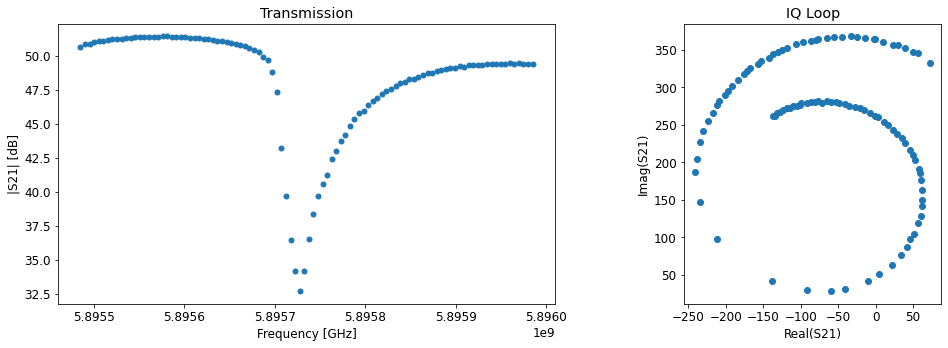

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plt.rcParams.update({'font.size': 12})

ax1.plot(lo_sweep_freqs+tones[0], 20 * np.log10(np.abs(iq_vals)), linestyle=" ", marker=".", markersize=10)
ax1.set_ylabel('|S21| [dB]')
ax1.set_xlabel('Frequency [GHz]')
ax1.set_title('Transmission')

    
ax2.plot(iq_vals.real, iq_vals.imag, 'o')
ax2.set_xlabel('Real(S21)')
ax2.set_aspect('equal')
ax2.set_ylabel('Imag(S21)')
ax2.set_title('IQ Loop')
plt.tight_layout()

## Find Resonant Frequency

In [57]:
res_freq = 5895.705
lo_res_freq = (res_freq*1e6-tones[0])*1e-6
if_board.set_lo(lo_res_freq)
iq_val_res = get_iq_point()

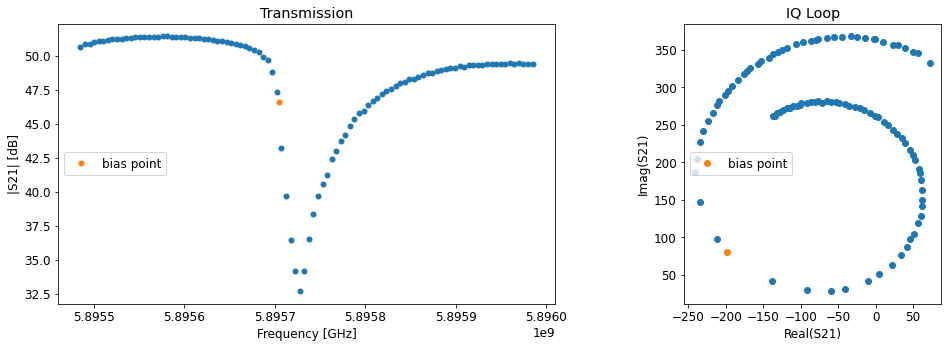

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plt.rcParams.update({'font.size': 12})

ax1.plot(lo_sweep_freqs+tones[0], 20 * np.log10(np.abs(iq_vals)), linestyle=" ", marker=".", markersize=10)
ax1.plot(lo_res_freq*1e6+tones[0], 20 * np.log10(np.abs(iq_val_res)), linestyle=" ", marker=".", markersize=10, label='bias point')
ax1.set_ylabel('|S21| [dB]')
ax1.set_xlabel('Frequency [GHz]')
ax1.set_title('Transmission')
ax1.legend(loc='center left')

    
ax2.plot(iq_vals.real, iq_vals.imag, 'o')
ax2.plot(iq_val_res.real, iq_val_res.imag,'o', label='bias point')
ax2.set_xlabel('Real(S21)')
ax2.set_aspect('equal')
ax2.set_ylabel('Imag(S21)')
ax2.set_title('IQ Loop')
ax2.legend(loc='center left')
plt.tight_layout()

# Rotate Loop

In [83]:
import scipy.optimize as opt
import scipy.signal as sig

def get_iq_points_rms(tones, n=1024):
    """
    Args:
        n: int
        how many points to average
    Returns: a single averaged iq data point captured from res channel 0
    """
    time.sleep(0.01)
    x = ol.capture.capture_iq(n, tap_location='iq')
    x.freebuffer()
    del x

    x = ol.capture.capture_iq(n, tap_location='iq')
    means = np.zeros((tones.size, 2))
    rmses = np.zeros((tones.size, 2))
    x[::,:tones.size,::].mean(axis=0, out=means)
    x[::,:tones.size,::].std(axis=0, out=rmses)

    x.freebuffer()
    del x
    return means[::,0] + 1j * means[::,1], rmses[::,0] + 1j * rmses[::,1]  

def sample_loops(overlay, if_board, tones, bandwidth = 150e3, lo_center = 6000.0, average = 1024, points = 64):
    LO_QUANT = 0.596

    if_board.set_lo(lo_center)
    ddc_tones = np.zeros(2048)
    ddc_tones[:tones.size]=tones
    phase_offsets = np.zeros_like(ddc_tones)
    ddc_centers = np.zeros(2048, dtype=np.complex64)
    ol.photon_pipe.reschan.ddccontrol_0.configure(ddc_tones, phase_offset=phase_offsets, loop_center=ddc_centers)
    
    loop_points = np.zeros((tones.size, points), dtype=np.csingle)
    loop_rmses = np.zeros((tones.size, points), dtype=np.csingle)
    spacing = LO_QUANT * np.floor(((bandwidth / points) / LO_QUANT))
    
    # These are not going to be actually quantized because FP but the LO algo on the IF Board is FP too
    lo_freqs = lo_center + (np.arange(points) * spacing - spacing * points // 2) / 1e6
    
    for i, f in enumerate(lo_freqs):
        if i % 8 == 0:
            print("Sweep #", i)
        if_board.set_lo(f, fractional=True, g2_mode=False, full_calibration=True)
        mu, sigma = get_iq_points_rms(tones, n = average)
        loop_points[::, i] = mu[:tones.size]
        loop_rmses[::, i] = sigma[:tones.size] / np.sqrt(average)
    
    return loop_points, loop_rmses, lo_freqs

def pointslope_intersect(
    m0, x0, y0,
    m1, x1, y1,
    m0r = 0, x0r = 0, y0r = 0,
    m1r = 0, x1r = 0, y1r = 0
):
    xin = (y0 - y1 + m1*x1 - m0*x0)
    xid = (m1 - m0)
    xi = xin / xid
    
    yip = xi - x0
    yi = y0 + m0 * yip
    
    xirn = np.sqrt(
        y0r**2 + y1r**2 +
        (m1 * x1 * np.sqrt((m1r/m1)**2 + (x1r / x1)**2))**2 +
        (m0 * x0 * np.sqrt((m0r/m0)**2 + (x0r / x0)**2))**2
    )
    xird = np.sqrt(m1r**2 + m0r**2)
    xir = xi * np.sqrt((xirn / xin)**2 + (xird / xid)**2)
    yirp = np.sqrt(xir**2 + x0r**2)
    yir = np.sqrt(y0r ** 2  + ((m0r / m0)**2 + (yirp / yip)**2)*((yip * m0)**2))
    
    return xi, yi, xir, yir

def slope_midpoint(x0, x1, y0, y1, x0r, x1r, y0r, y1r):
    md = x1 - x0
    mn = y1 - y0
    
    mnr = np.sqrt(y1r**2 + y0r**2)
    mdr = np.sqrt(x1r**2 + x0r**2)
    
    m = mn / md
    mr = m * np.sqrt((mnr / mn) ** 2 + (mdr / md) ** 2)
    
    ymidr = mnr / 2
    xmidr = mdr / 2
    
    xmid = (x1 + x0) / 2
    ymid = (y1 + y0) / 2
    
    return m, mr, xmid, ymid, xmidr, ymidr

def approximate_center(i, q, ir, qr, plot = None, holdoff = 6):
    assert i.size == q.size

    mi = q.size // 2
    
    cestimates = np.zeros((q.size // 2 - 1 - holdoff, 2))
    cestimaters = np.zeros((q.size // 2 - 1 - holdoff, 2))
    
    for p in range(holdoff, q.size // 2 - 1):
        mp, mpr, xmp, ymp, xmpr, ympr = slope_midpoint(
            i[mi], i[mi + p], q[mi], q[mi + p],
            ir[mi], ir[mi + p], qr[mi], qr[mi + p]
        )
        mn, mnr, xmn, ymn, xmnr, ymnr = slope_midpoint(
            i[mi], i[mi - p], q[mi], q[mi - p],
            ir[mi], ir[mi - p], qr[mi], qr[mi - p]
        )
        mpi, mpir = -1 / mp, mpr / (mp**2)
        mni, mnir = -1 / mn, mnr / (mn**2)
        xc, yc, xcr, ycr = pointslope_intersect(
            mpi, xmp, ymp,
            mni, xmn, ymn,
            mpir, xmpr, ympr,
            mnir, xmnr, ymnr
        )
        cestimates[p - holdoff][0] = xc
        cestimates[p - holdoff][1] = yc
        cestimaters[p - holdoff][0] = xcr
        cestimaters[p - holdoff][1] = ycr
    
    if plot:
        plot.errorbar(cestimates[::,0], cestimates[::,1], cestimaters[::,0], cestimaters[::,1])
        print(cestimates, cestimaters)
    
    cestimate = np.sum(cestimates / (cestimaters ** 2), axis = 0) / np.sum(1 / (cestimaters ** 2), axis = 0)

    return (cestimate[0], cestimate[1]), np.sqrt((cestimate[0] - i[mi]) ** 2 + (cestimate[1] - q[mi]) ** 2)

def find_truecenter(i, q, irms, qrms, center, radius, plot = None):
    i_apcent = i - center[0]
    q_apcent = q - center[1]

    angles = np.arctan2(q_apcent, i_apcent)
    middle = (angles[0] + angles[-1]) / 2
    rotation = np.pi / 2 - middle

    i_apcentrot = i_apcent * np.cos(rotation) - q_apcent * np.sin(rotation)
    q_apcentrot = i_apcent * np.sin(rotation) + q_apcent * np.cos(rotation)
    
    model = lambda i, r, i0, q0: np.sqrt(r**2 - (i - i0)**2) + q0
    print(i, q)
    print(i_apcentrot, q_apcentrot)
    if plot:
        plot.plot(i_apcentrot, q_apcentrot)
    popt, pcov = opt.curve_fit(model, i_apcentrot, q_apcentrot, sigma = np.sqrt(irms**2 + qrms**2), p0 = (radius, 0, 0))
    true_center = (
        center[0] + popt[1]*np.cos(-rotation) - popt[2]*np.sin(-rotation),
        center[1] + popt[1]*np.sin(-rotation) + popt[2]*np.cos(-rotation)
    )
    true_radius = popt[0]
    return true_center, true_radius

def quantize_rotation(rotation, bits = 8):
    if rotation == np.pi:
        rotation = -np.pi
    return np.floor(rotation * (1 << (bits - 1)) / np.pi) * np.pi / (1 << (bits - 1))

def rotate_and_center(overlay, ifboard, tones, targets = None, lo_center = 6000, program = False, fit = False, plot = False):
    if not targets:
        targets = np.zeros_like(tones)
    iqs, iqrs, freqs = sample_loops(overlay, ifboard, tones, lo_center = lo_center, average = 32768)
    
    phase_offsets = np.zeros(2048)
    ddc_centers = np.zeros(2048, dtype=np.complex64)
    for t in range(tones.size):
        i = iqs[t].real
        q = iqs[t].imag
        if plot:
            fig, ax = plt.subplots(1, dpi = 300)
            ax.set_aspect('equal')
            ax.set_title(str(tones[t]))
            ax.plot(i, q)

        ri = iqrs[t].real
        rq = iqrs[t].imag

        target = targets[t]

        approxc, approxr = approximate_center(i, q, ri, rq, plot = ax if plot else False)
        if fit:
            center, radius = find_truecenter(i, q, ri, rq, approxc, approxr, plot = ax if plot else False)
        else:
            center = approxc
            radius = approxr
        print(center, radius)
        
        if plot:
            ax.add_patch(plt.Circle(approxc, approxr, color = 'b', fill = False))
            ax.add_patch(plt.Circle(center, radius, color = 'r', fill = False))
            ax.scatter(*center)
        
        current_rotation = np.arctan2(q[q.size // 2] - center[1], i[i.size // 2] - center[0])
        rotation = quantize_rotation(target - current_rotation)
        rotated_center = (
            np.cos(rotation) * center[0] - np.sin(rotation) * center[1],
            np.sin(rotation) * center[0] + np.cos(rotation) * center[1]
        )

        iq_offset = (
            rotated_center[0],
            rotated_center[1]
        )

        phase_offsets[t] = rotation
        ddc_centers[t] = rotated_center[0] + rotated_center[1] * 1j
        if plot:
            #ax.set_xlim(-300, 300)
            #ax.set_ylim(-300, 300)
            plt.show()
    
    ddc_centers /= 2**15
    
    if program:
        overlay.photon_pipe.reschan.ddccontrol_0.configure(ddc_tones, phase_offset=phase_offsets, loop_center=ddc_centers)
    return phase_offsets, ddc_centers, i, q, freqs

offsets, centers, i, q, freqs = rotate_and_center(ol, ifb, tones, targets = [-3*np.pi/4], lo_center = lo_res_freq, plot=False, program = True)

Sweep # 0
Sweep # 8
Sweep # 16
Sweep # 24
Sweep # 32
Sweep # 40
Sweep # 48
Sweep # 56
(-84.37777190100633, 180.7913951935834) 152.79361034124076


## Re-Sweep

In [84]:
if_board = ifb
iq_vals = np.zeros(lo_sweep_freqs.size, dtype=np.complex64)
lo_settings = np.zeros(lo_sweep_freqs.size)
for x in range(len(lo_sweep_freqs)):
    if_board.set_lo(lo_sweep_freqs[x] * 1e-6)
    iq_vals[x] = get_iq_point()

In [85]:
if_board.set_lo(lo_res_freq)
iq_val_res = get_iq_point()

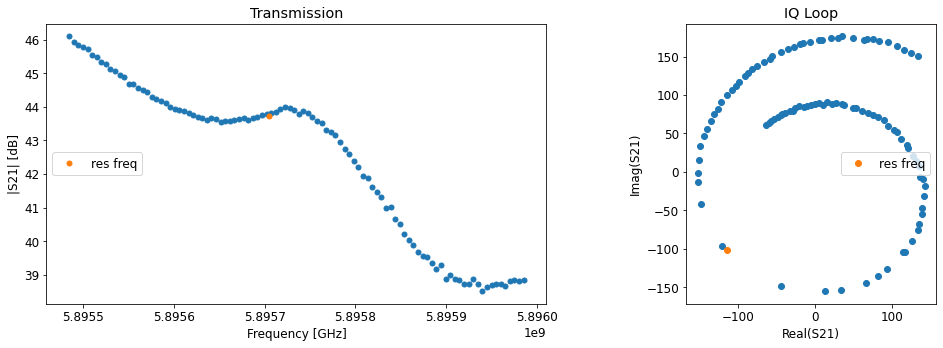

In [86]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plt.rcParams.update({'font.size': 12})

ax1.plot(lo_sweep_freqs+tones[0], 20 * np.log10(np.abs(iq_vals)), linestyle=" ", marker=".", markersize=10)
ax1.plot(lo_res_freq*1e6+tones[0], 20 * np.log10(np.abs(iq_val_res)), linestyle=" ", marker=".", markersize=10, label='res freq')
ax1.set_ylabel('|S21| [dB]')
ax1.set_xlabel('Frequency [GHz]')
ax1.set_title('Transmission')
ax1.legend(loc='center left')

    
ax2.plot(iq_vals.real, iq_vals.imag, 'o')
ax2.plot(iq_val_res.real, iq_val_res.imag,'o', label='res freq')
ax2.set_xlabel('Real(S21)')
ax2.set_aspect('equal')
ax2.set_ylabel('Imag(S21)')
ax2.set_title('IQ Loop')
ax2.legend(loc='center right')
plt.tight_layout()

# Clear Variables

In [87]:
del phase, adc_capture_data, i, q

NameError: name 'adc_capture_data' is not defined

# Take Data

In [88]:
def cap_cordic_compare(n_points=1024):
    """A helper function to capture data just before the lowpass and after conversion to phase"""
    x = ol.capture.capture_iq(n_points, [0,1], tap_location='ddciq')
    riq = np.array(x)
    x.freebuffer()
    x = ol.capture.capture_phase(n_points, [0,1], tap_location='filtphase')
    phase = np.array(x)
    x.freebuffer()
    riq = riq[..., 0] + riq[..., 1] * 1j
    return riq, phase

# Fine Tune Laser 

In [91]:
x = ol.capture.capture_phase(2**19, [0,1], tap_location='rawphase')
phase = np.array(x)
x.freebuffer()
laser_on = phase[:,0]/(2**15-1)

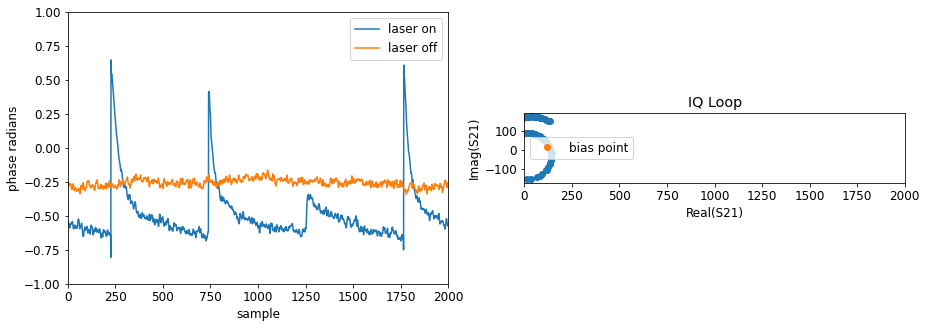

In [94]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plt.rcParams.update({'font.size': 12})

ax1.plot(laser_on, label='laser on')
ax1.plot(laser_off, label='laser off')
ax1.set_ylabel('phase radians')
ax1.set_xlabel('sample')
ax1.legend(loc = 'upper right')
ax1.set_ylim([-1.0,1.0])
ax1.set_xlim(0,2000)

ax2.plot(iq_vals.real, iq_vals.imag, 'o')
ax2.plot(iq_val_res.real, iq_val_res.imag,'o', label='bias point')
ax2.set_xlabel('Real(S21)')
ax2.set_aspect('equal')
ax2.set_ylabel('Imag(S21)')
ax2.set_title('IQ Loop')
ax2.set_xlim(0,2000)
ax2.legend(loc='center left')

## Figure Out Count Rate

In [142]:
#from mkidreadoutanalysis.mkidreadout import MKIDReadout

In [143]:
readout = MKIDReadout()
readout.trigger(-laser_on, fs = 1e6, threshold=-0.15, deadtime=50)
total_photons=(readout.trig>0).sum()
print(f'total_photons: {total_photons}')
print(f'count rate:{total_photons/(2**19/1e6)} cps')
print(f'need: {30000/total_photons} captures.')
#readout.plot_triggers(laser_on, fs=1e6, energies=True)
#plt.xlim([55000,65000])

total_photons: 55
count rate:104.9041748046875 cps
need: 545.4545454545455 captures.


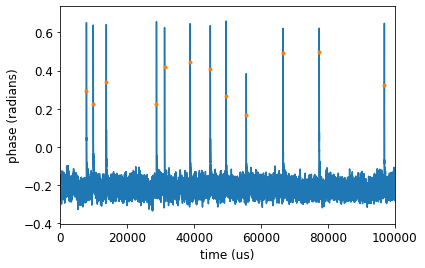

In [144]:
energies = False
tvec = (np.arange(laser_on.shape[0])*1/1e6)*1e6
plt.plot(tvec, laser_on)
plt.plot((tvec[readout.trig]), (laser_on[readout.trig]), '.')
plt.xlim(0,100000)
plt.xlabel('time (us)')
plt.ylabel('phase (radians)')
# plt.xticks(rotation = 45)
if energies:
    plt.plot(tvec[self.photon_energy_idx], data[self.photon_energy_idx], 'o')

In [98]:
import os

# Capture Dark Data

In [118]:
folder = '/nfs/wheatley/majid_jitter_test_10_17_23'

for i in range(0,1):
    iq_dark, phase_dark = cap_cordic_compare(2**19)

    iq_data_dark = iq_dark[:,0]
    phase_data_dark = phase_dark[:,0]/(2**15-1)

    del iq_dark, phase_dark
    file_name = f'wf_ellison3_6000_650GHz_dark{i:002d}.npz'
    np.savez(os.path.join(folder, file_name),iq_dark=iq_data_dark, phase_dark=phase_data_dark)

In [119]:
del iq_data_dark, phase_data_dark

In [96]:
import os

# Get I and Q

## Save Data in Loop

In [97]:
folder = '/home/xilinx/jupyter_notebooks/majid_tests_12_5_23'

for i in range(0,10):
    iq_data, phase_data = cap_cordic_compare(2**19)

    iq_data_save = iq_data[:,0]
    phase_data_save = phase_data[:,0]/(2**15-1)

    file_name = f'wf_ellison2_5_995735GHz_pulsed_laser_515nm_500usec_period_5ns_pulsewidth{i:002d}.npz'
    np.savez(os.path.join(folder, file_name),iq_data=iq_data_save, phase_data=phase_data_save)
del iq_data, phase_data, iq_data_save, phase_data_save